In [2]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_misc, utils_io, utils_plotting, utils_mutual_information, utils_statistics, utils_spectrogram, utils_plotting_spectrogram
from lib_data import DATA_IO

fs                  = 2048
PATH_CURR           = os.path.abspath(os.curdir)    # current code
PATH                = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situate

# 1. Calculate Tap-Wise Time-Frequency Activity

In [3]:
df_TAPPING_events   = pd.read_pickle(DATA_IO.path_events + "ECoG_EVENTS.pkl")

## LID severity 3: noLID_noDOPA, noLID_DOPA, LID
df_TAPPING_events["LID"] = df_TAPPING_events.dyskinesia_arm.copy()
df_TAPPING_events.loc[(df_TAPPING_events['LID']!= "none") , "LID"]          = 'LID'
df_TAPPING_events.loc[(df_TAPPING_events['LID']== "none") & (df_TAPPING_events['event_start_time'] <= 30 ), "LID"] = 'noLID_noDOPA'
df_TAPPING_events.loc[(df_TAPPING_events['LID']== "none") & (df_TAPPING_events['event_start_time'] > 30 ) , "LID"] = 'noLID_DOPA'

df_controlateral    = df_TAPPING_events[df_TAPPING_events.event_laterality != df_TAPPING_events.ECoG_hemisphere]
df_controlateral    = utils_misc.get_onset_and_offset_aligned_recordings(df_controlateral, fs=fs)
df_controlateral    = df_controlateral[["patient", "event_no", "ECoG_hemisphere", "ECoG_channel", "recording_onset_aligned","recording_offset_aligned","LID"]]
df_controlateral.reset_index(inplace=True, drop=True)

baseline_recordings = utils_io.load_baseline_recordings(recording_type="ECoG")

Patient 008: does not have right hemisphere baseline recordings
Patient 009: does not have right hemisphere baseline recordings
Patient 010: does not have left hemisphere baseline recordings
Patient 012: does not have left hemisphere baseline recordings
Patient 013: does not have left hemisphere baseline recordings
Patient 014: does not have left hemisphere baseline recordings
Patient 016: does not have left hemisphere baseline recordings
Patient 017: does not have left hemisphere baseline recordings
Patient 020: does not have left hemisphere baseline recordings
Patient 021: does not have left hemisphere baseline recordings
Patient 022: does not have left hemisphere baseline recordings
Patient 023: does not have left hemisphere baseline recordings
Patient 101: does not have right hemisphere baseline recordings
Patient 101: does not have left hemisphere baseline recordings
Patient 102: does not have right hemisphere baseline recordings
Patient 102: does not have left hemisphere baseline

In [7]:
dataset               = pd.DataFrame(df_controlateral)
dataset["hemisphere"] = dataset.ECoG_hemisphere
dataset["channel"]    = dataset.ECoG_channel
dataset.reset_index(inplace=True, drop=True)

df_spectrogram        = utils_spectrogram.measure_normalized_multitaper_spectrograms_for_taps(dataset, fs, baseline_recordings)
df_spectrogram.to_pickle(DATA_IO.path_events + "time_frequency_activity/ECOG_TFA") 

Patient 008
---> baseline TFR measurement is completed...
------> left - LID - p_008_right_tapping1
------> left - LID - p_008_right_tapping2
------> left - LID - p_008_right_tapping3
------> left - LID - p_008_right_tapping4
------> left - LID - p_008_right_tapping5
------> left - LID - p_008_right_tapping6
------> left - LID - p_008_right_tapping7
------> left - LID - p_008_right_tapping8
------> left - LID - p_008_right_tapping9
------> left - LID - p_008_right_tapping10
------> left - LID - p_008_right_tapping11
------> left - LID - p_008_right_tapping12
------> left - LID - p_008_right_tapping13
------> left - LID - p_008_right_tapping14
------> left - LID - p_008_right_tapping15
------> left - LID - p_008_right_tapping16
------> left - LID - p_008_right_tapping17
------> left - LID - p_008_right_tapping18
------> left - LID - p_008_right_tapping19
------> left - LID - p_008_right_tapping20
------> left - LID - p_008_right_tapping21
------> left - LID - p_008_right_tapping22
-----

# 2. Load Channel and Severity-Wise Time-Frequency Activity

In [3]:
df_spectrogram              = pd.read_pickle(DATA_IO.path_events + "time_frequency_activity/ECOG_TFA") 
df_spectrogram_LID          = df_spectrogram[df_spectrogram.severity=="LID"]
df_spectrogram_noLID_noDOPA = df_spectrogram[df_spectrogram.severity=="noLID_noDOPA"]
df_spectrogram_noLID_DOPA   = df_spectrogram[df_spectrogram.severity=="noLID_DOPA"]

# 3. Plot Spectrograms

In [20]:
# measure mean spectrograms
TFR_avg_onset_noLID_noDOPA  = np.nanmean(list(df_spectrogram_noLID_noDOPA[df_spectrogram_noLID_noDOPA["onset_aligned_normalized"].apply(lambda x: isinstance(x, np.ndarray))].onset_aligned_normalized), axis=0)
TFR_avg_offset_noLID_noDOPA = np.nanmean(list(df_spectrogram_noLID_noDOPA[df_spectrogram_noLID_noDOPA["offset_aligned_normalized"].apply(lambda x: isinstance(x, np.ndarray))].offset_aligned_normalized), axis=0)
TFR_avg_onset_noLID_DOPA    = np.nanmean(list(df_spectrogram_noLID_DOPA[df_spectrogram_noLID_DOPA["onset_aligned_normalized"].apply(lambda x: isinstance(x, np.ndarray))].onset_aligned_normalized), axis=0)
TFR_avg_offset_noLID_DOPA   = np.nanmean(list(df_spectrogram_noLID_DOPA[df_spectrogram_noLID_DOPA["offset_aligned_normalized"].apply(lambda x: isinstance(x, np.ndarray))].offset_aligned_normalized), axis=0)
TFR_avg_onset_LID           = np.nanmean(list(df_spectrogram_LID[df_spectrogram_LID["onset_aligned_normalized"].apply(lambda x: isinstance(x, np.ndarray))].onset_aligned_normalized), axis=0)
TFR_avg_offset_LID          = np.nanmean(list(df_spectrogram_LID[df_spectrogram_LID["offset_aligned_normalized"].apply(lambda x: isinstance(x, np.ndarray))].offset_aligned_normalized), axis=0)

# remove extra dimension: from  (1, 87, 8192) to (87, 8192)
TFR_avg_onset_noLID_noDOPA  = np.squeeze(TFR_avg_onset_noLID_noDOPA) 
TFR_avg_offset_noLID_noDOPA = np.squeeze(TFR_avg_offset_noLID_noDOPA) 
TFR_avg_onset_noLID_DOPA    = np.squeeze(TFR_avg_onset_noLID_DOPA) 
TFR_avg_offset_noLID_DOPA   = np.squeeze(TFR_avg_offset_noLID_DOPA) 
TFR_avg_onset_LID           = np.squeeze(TFR_avg_onset_LID) 
TFR_avg_offset_LID          = np.squeeze(TFR_avg_offset_LID) 

<Figure size 640x480 with 0 Axes>

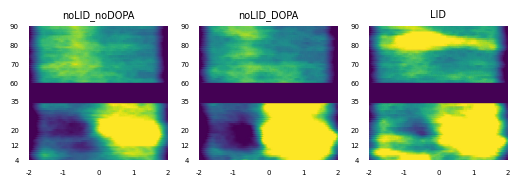

In [21]:
plt             = utils_plotting.get_figure_template()
ax_noLID_noDOPA = plt.subplot2grid((80, 40), (0, 0) , colspan=10, rowspan=17)
ax_noLID_DOPA   = plt.subplot2grid((80, 40), (0, 12) , colspan=10, rowspan=17)
ax_LID          = plt.subplot2grid((80, 40), (0, 24), colspan=10, rowspan=17)

ax_noLID_noDOPA = utils_plotting_spectrogram.plot_mean_spectrogram(TFR_avg_offset_noLID_noDOPA, group = "noLID_noDOPA", time_vector=np.linspace(-2,2,fs*4), 
                                                                   vmin=-40, vmax=40, cmap="viridis", axis=ax_noLID_noDOPA)
ax_noLID_DOPA   = utils_plotting_spectrogram.plot_mean_spectrogram(TFR_avg_offset_noLID_DOPA, group = "noLID_DOPA", time_vector=np.linspace(-2,2,fs*4), 
                                                                   vmin=-40, vmax=40, cmap="viridis", axis=ax_noLID_DOPA)
ax_LID          = utils_plotting_spectrogram.plot_mean_spectrogram(TFR_avg_offset_LID, group = "LID", time_vector=np.linspace(-2,2,fs*4), 
                                                                   vmin=-40, vmax=40, cmap="viridis", axis=ax_LID)

plt.savefig(DATA_IO.path_figure + "spectrogram/cortex_spectrogram_offset.svg", dpi=1200)

In [14]:
df_spectrogram_LID["dyskinesia_group"]    = 1 # assign numeric value 1 to dyskinetic event
df_spectrogram_noLID["dyskinesia_group"]  = 0 # assign numeric value 0 to dyskinetic event

# concat two dataframes (no-LID and LID)
df_offset_aligned = pd.concat([df_spectrogram_LID[["offset_aligned_normalized","dyskinesia_group"]], 
                               df_spectrogram_noLID[["offset_aligned_normalized","dyskinesia_group"]]], 
                              ignore_index=True)

# rename the column
df_offset_aligned["spectrogram"] = df_offset_aligned["offset_aligned_normalized"]
df_offset_aligned                = df_offset_aligned[["spectrogram", "dyskinesia_group"]]
df_offset_aligned                = df_offset_aligned.dropna(subset=['spectrogram']) # removing nan spectrogram  

# downsample spectrograms with means to reduce time resolution for mutual information calculation
downsampled_spectrograms = []
for index,row in df_offset_aligned.iterrows():
    downsampled_spectrograms.append(utils_misc.spectrogram_downsampling_with_mean(row.spectrogram, fs=2048, time_interval_in_second=0.02)) # 20 ms. bins
    
df_offset_aligned["spectrogram"] = downsampled_spectrograms

n_rows = np.shape(df_offset_aligned.iloc[0].spectrogram)[0]
n_cols = np.shape(df_offset_aligned.iloc[0].spectrogram)[1]

print(str(n_rows) +  " x " + str(n_cols)) # time datapoints dropped from 8192 to 204

87 x 204


Each spectrogram contains 87 frequency components (frequency resolution 1 from 4 to 90 Hz) and 204 (binned with 20 ms)
time points equal to 4 seconds time period around event onset/offset [-2 seconds to +2 seconds]

##  5.1 Measure Mutual Information and Significance

In [17]:
matrix_MI, matrix_MI_pvalues, matrix_bootstrap_max = utils_mutual_information.measure_spectrogram_mi(df_offset_aligned, n_iterations=100)

4 Hz mutual information measurement started
5 Hz mutual information measurement started
6 Hz mutual information measurement started
7 Hz mutual information measurement started
8 Hz mutual information measurement started
9 Hz mutual information measurement started
10 Hz mutual information measurement started
11 Hz mutual information measurement started
12 Hz mutual information measurement started
13 Hz mutual information measurement started
14 Hz mutual information measurement started
15 Hz mutual information measurement started
16 Hz mutual information measurement started
17 Hz mutual information measurement started
18 Hz mutual information measurement started
19 Hz mutual information measurement started
20 Hz mutual information measurement started
21 Hz mutual information measurement started
22 Hz mutual information measurement started
23 Hz mutual information measurement started
24 Hz mutual information measurement started
25 Hz mutual information measurement started
26 Hz mutual inf

## 5.2. Save Measured MI and P-Values

In [27]:
with open(DATA_IO.path_events+'mutual_information/ECOG/matrix_MI.npy', 'wb') as f: np.save(f, matrix_MI)
with open(DATA_IO.path_events+'mutual_information/ECOG/matrix_MI_pvalues.npy', 'wb') as f: np.save(f, matrix_MI_pvalues)
with open(DATA_IO.path_events+'mutual_information/ECOG/matrix_bootstrap_max.npy', 'wb') as f: np.save(f, matrix_bootstrap_max)

## 5.3. Load Measured MI and P-Values

In [8]:
matrix_MI              = np.load(DATA_IO.path_events+'mutual_information/ECOG/matrix_MI.npy')
matrix_MI_pvalues      = np.load(DATA_IO.path_events+'mutual_information/ECOG/matrix_MI_pvalues.npy')
matrix_bootstrap_max   = np.load(DATA_IO.path_events+'mutual_information/ECOG/matrix_bootstrap_max.npy')

significance_threshold = np.percentile(matrix_bootstrap_max.flatten(), 95)
MI_significant         = matrix_MI_pvalues>=significance_threshold

## 5.4 Plot Time-Frequency MI

<Figure size 640x480 with 0 Axes>

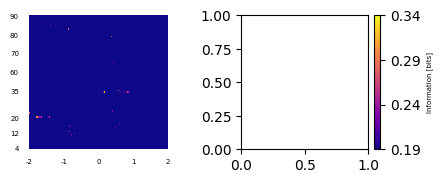

In [13]:
import matplotlib.colors as mcolors

plt        = utils_plotting.get_figure_template()
axis       = plt.subplot2grid((80, 40), (0, 0) , colspan=10, rowspan=17)
ax_cbar    = plt.subplot2grid((80, 40), (0, 15), colspan=10, rowspan=17)
axis, mesh = utils_plotting_spectrogram.plot_spectrogram_MI(matrix_MI, MI_significant, significance_threshold, cmap="plasma", axis=axis)

mesh.set_clim(significance_threshold, np.max(matrix_MI))
cbar1 = plt.colorbar(mesh, ax=ax_cbar, orientation='vertical', fraction=0.05, pad=0.04)
custom_ticks = np.linspace(significance_threshold, np.max(matrix_MI), 4)
cbar1.set_ticks(custom_ticks)
cbar1.set_ticklabels([f"{tick:.2f}" for tick in custom_ticks])
cbar1.set_label("Information [bits]", fontsize=utils_plotting.LABEL_SIZE)

plt.savefig(DATA_IO.path_figure + 'mutual_information/cortex_spectrogram_MI.svg', dpi=1200)